In [2]:
# -*- coding: utf-8 -*-
from keras.layers import BatchNormalization, Activation, Conv1D, MaxPooling1D, ZeroPadding1D, InputLayer
from keras.models import Sequential
import numpy as np
import librosa

Using TensorFlow backend.


In [3]:
def preprocess(audio):
    audio *= 256.0  # SoundNet needs the range to be between -256 and 256
    # reshaping the audio data so it fits into the graph (batch_size, num_samples, num_filter_channels)
    audio = np.reshape(audio, (1, -1, 1))
    return audio

In [4]:
def load_audio(audio_file):
    sample_rate = 22050  # SoundNet works on mono audio files with a sample rate of 22050.
    audio, sr = librosa.load(audio_file, dtype='float32', sr=22050, mono=True)
    audio = preprocess(audio)
    return audio

'MODELO COMPILADO CON VGG16': 401 CLASES

In [5]:
def build_model():
    """
    Builds up the SoundNet model and loads the weights from a given model file (8-layer model is kept at models/sound8.npy).
    :return:
    """
    model_weights = np.load('models/sound8.npy',allow_pickle=True, encoding = 'latin1').item()
    print(type(model_weights))
    model = Sequential()
    model.add(InputLayer(batch_input_shape=(1, None, 1)))

    filter_parameters = [{'name': 'conv1', 'num_filters': 16, 'padding': 32,
                          'kernel_size': 64, 'conv_strides': 2,
                          'pool_size': 8, 'pool_strides': 8},

                         {'name': 'conv2', 'num_filters': 32, 'padding': 16,
                          'kernel_size': 32, 'conv_strides': 2,
                          'pool_size': 8, 'pool_strides': 8},

                         {'name': 'conv3', 'num_filters': 64, 'padding': 8,
                          'kernel_size': 16, 'conv_strides': 2},

                         {'name': 'conv4', 'num_filters': 128, 'padding': 4,
                          'kernel_size': 8, 'conv_strides': 2},

                         {'name': 'conv5', 'num_filters': 256, 'padding': 2,
                          'kernel_size': 4, 'conv_strides': 2,
                          'pool_size': 4, 'pool_strides': 4},

                         {'name': 'conv6', 'num_filters': 512, 'padding': 2,
                          'kernel_size': 4, 'conv_strides': 2},

                         {'name': 'conv7', 'num_filters': 1024, 'padding': 2,
                          'kernel_size': 4, 'conv_strides': 2},

                         {'name': 'conv8_2', 'num_filters': 401, 'padding': 0,
                          'kernel_size': 8, 'conv_strides': 2},
                         ]

    for x in filter_parameters:
        model.add(ZeroPadding1D(padding=x['padding']))
        model.add(Conv1D(x['num_filters'],
                         kernel_size=x['kernel_size'],
                         strides=x['conv_strides'],
                         padding='valid'))
        weights = model_weights[x['name']]['weights'].reshape(model.layers[-1].get_weights()[0].shape)
        biases = model_weights[x['name']]['biases']

        model.layers[-1].set_weights([weights, biases])

        if 'conv8' not in x['name']:
            gamma = model_weights[x['name']]['gamma']
            beta = model_weights[x['name']]['beta']
            mean = model_weights[x['name']]['mean']
            var = model_weights[x['name']]['var']


            model.add(BatchNormalization())
            model.layers[-1].set_weights([gamma, beta, mean, var])
            model.add(Activation('relu'))
        if 'pool_size' in x:
            model.add(MaxPooling1D(pool_size=x['pool_size'],
                                   strides=x['pool_strides'],
                                   padding='valid'))

    return model



In [6]:
def predict_scene_from_audio_file(audio_file):
    model = build_model()
    audio = load_audio(audio_file)
    print(audio.shape)
    return model.predict(audio)

In [7]:
def predictions_to_scenes(prediction):
    scenes = []
    with open('categories/categories_places2.txt', 'r') as f:
        categories = f.read().split('\n')
        for p in range(prediction.shape[1]):
            scenes.append(categories[np.argmax(prediction[0, p, :])])
    return scenes

In [8]:
prediction = predict_scene_from_audio_file('railroad_audio.wav')
print(prediction.shape)

<class 'dict'>
(1, 439530, 1)
(1, 4, 401)


In [9]:
 print(predictions_to_scenes(prediction))

['/r/railroad_track', '/r/railroad_track', '/r/railroad_track', '/t/train_station/platform']


In [10]:
prediction2 = predict_scene_from_audio_file('demo.mp3')

<class 'dict'>
(1, 7077312, 1)


In [11]:
print(prediction2.shape)
print(predictions_to_scenes(prediction2))

(1, 105, 401)
['/s/sky', '/s/sky', '/s/sky', '/a/art_gallery', '/a/art_gallery', '/a/art_gallery', '/a/art_gallery', '/a/art_gallery', '/a/art_gallery', '/a/art_gallery', '/a/art_gallery', '/a/art_gallery', '/a/art_gallery', '/a/art_gallery', '/a/art_gallery', '/a/aquarium', '/m/music_studio', '/m/music_studio', '/m/music_studio', '/m/music_studio', '/a/art_gallery', '/a/art_gallery', '/a/art_gallery', '/m/music_studio', '/m/music_studio', '/m/music_studio', '/m/music_studio', '/m/music_studio', '/m/music_studio', '/m/music_studio', '/m/music_studio', '/m/music_studio', '/m/music_studio', '/m/music_studio', '/m/music_studio', '/a/aquarium', '/a/aquarium', '/a/aquarium', '/a/art_gallery', '/a/art_gallery', '/a/art_gallery', '/a/art_gallery', '/a/art_gallery', '/a/art_gallery', '/a/art_gallery', '/a/art_gallery', '/a/art_gallery', '/a/art_gallery', '/a/art_gallery', '/m/music_studio', '/m/music_studio', '/m/music_studio', '/m/music_studio', '/m/music_studio', '/m/music_studio', '/m/music

#prediction = predict_scene_from_audio_file('rooster.wav') 


### The length of the audio 'rooster.wav' is not enough

In [12]:
prediction3 = predict_scene_from_audio_file('airplane.wav')

<class 'dict'>
(1, 311841, 1)


In [13]:
 print(predictions_to_scenes(prediction3))

['/r/railroad_track', '/t/train_railway']


In [14]:
import matplotlib.pyplot as plt
def figura(prediction):    
    print(prediction.shape) 
    #print(prediction[0,0,:])
    fig, ax = plt.subplots()
    ax.plot(prediction[0,0,:])
    ax.plot(prediction[0,1,:],c='r')
plt.show()

    

(1, 4, 401)


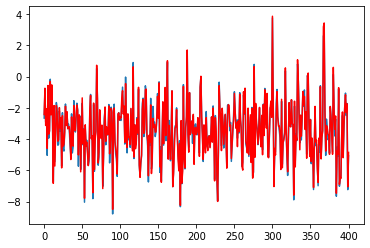

In [15]:
figura(prediction)

In [16]:
model = build_model()
model.summary()

<class 'dict'>
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding1d_25 (ZeroPaddi (1, None, 1)              0         
_________________________________________________________________
conv1d_25 (Conv1D)           (1, None, 16)             1040      
_________________________________________________________________
batch_normalization_22 (Batc (1, None, 16)             64        
_________________________________________________________________
activation_22 (Activation)   (1, None, 16)             0         
_________________________________________________________________
max_pooling1d_10 (MaxPooling (1, None, 16)             0         
_________________________________________________________________
zero_padding1d_26 (ZeroPaddi (1, None, 16)             0         
_________________________________________________________________
conv1d_26 (Conv1D)           (1, None, 

In [17]:
from keras import backend as K

#Function to obtain the output of Max pooling 1d24 (pool5)
get_22th_layer_output = K.function([model.layers[0].input],
                                  [model.layers[22].output])


In [18]:
import pandas as pd
test = pd.read_csv('D:/Project/ESC-50-master/meta/esc50.csv',sep=',')
data = []
list_target = []
list_category = []


for file_name, target, category,esc10 in zip(list(test['filename']), 
                                       list(test['target']), 
                                       list(test['category']),
                                       list(test['esc10'])):
        if esc10 == True:
            audio = load_audio('D:/Project/ESC-50-master/audio/'+file_name)
            data.append(audio)
            list_target.append(target)
            list_category.append(category)  


In [31]:
#get = get_22th_layer_output([data[155]])[0]
#get = model.predict([data[155]])
datos = np.asarray([data[155],data[155]]).reshape(1,-1,1)
print(datos.shape)

InvalidArgumentError:  Computed output size would be negative: -1 [input_size: 4, effective_filter_size: 8, stride: 2]
	 [[node conv1d_32/convolution (defined at C:\Users\wangx\.conda\envs\audio\lib\site-packages\keras\backend\tensorflow_backend.py:3009) ]] [Op:__inference_keras_scratch_graph_6477]

Function call stack:
keras_scratch_graph


# ventana de trabajo 5 seg

In [20]:


p = model.predict(datos) #-dgfsdfgsdfgdfg---menores a 5 segundos no funciona en el ultimo nivel
print(p.shape)
print(predictions_to_scenes(p))
tensor = get.reshape(1,-1)
print(tensor.shape)

(1, 1, 401)
['/p/parking_garage/outdoor']


NameError: name 'get' is not defined

In [21]:
#audio 1-172649-b-40 helicopter numero 5 en data
datos = np.asarray([data[5],data[5],data[5]]).reshape(1,-1,1)
print(datos.shape)
p = model.predict(datos) #-dgfsdfgsdfgdfg---menores a 5 segundos no funciona en el ultimo nivel
print(p.shape)
print(predictions_to_scenes(p))
tensor = get.reshape(1,-1)
print(tensor.shape)

(1, 330750, 1)
(1, 2, 401)
['/p/parking_lot', '/r/runway']


NameError: name 'get' is not defined

In [22]:

def getActivations(data,number_layer):
    intermediate_tensor = []
    get_layer_output = K.function([model.layers[0].input],
                                  [model.layers[number_layer].output])
    for audio in data:
        #getHiddenRepresentation       
        layer_output = get_layer_output([audio])[0]
        tensor = layer_output.reshape(1,-1)
        intermediate_tensor.append(tensor[0])
    return intermediate_tensor

In [23]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from time import time
def toTSNE(intermediate_tensor, target,number_layer,ax):
    t0 = time()
    #define dimension of the graph
    tsne = TSNE(n_components=2, random_state=0)
    #assign activation from data and obtain tsne representation
    intermediates_tsne = tsne.fit_transform(intermediate_tensor)
    
    ax.scatter(x = intermediates_tsne[:,0], y=intermediates_tsne[:,1],c = target, alpha = 0.7,cmap = plt.cm.Spectral)  
    ax.title("TSNE layer %i (time %.2fs)" % (number_layer,time() - t0))
    ax.colorbar()
    
    
    
    


In [24]:
activations = getActivations(data,22)

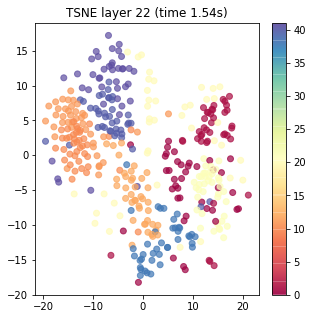

In [25]:
#Visualisation output hidden layer pool 5
fig = plt.figure(figsize=(5,5))
toTSNE(activations,list_target,22,plt)

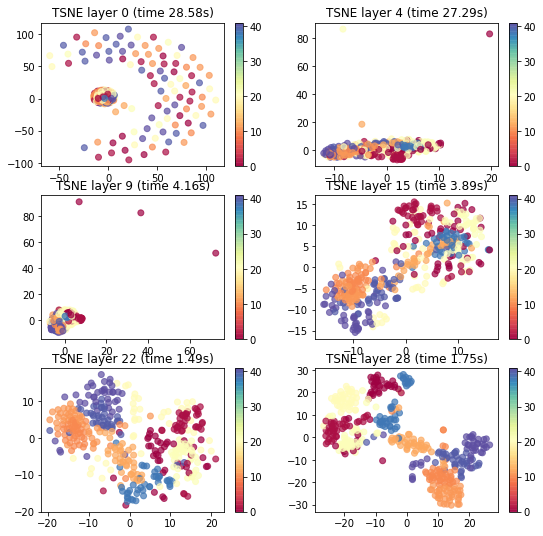

In [27]:
layers = [0,4,9,15,22,28]

%matplotlib inline
p = 1

fig = plt.figure(figsize=(9,9))
for c,i in enumerate(layers):
    ax = fig.add_subplot(3,2,c+1)
    activations = getActivations(data,i)
    toTSNE(activations,list_target,i,plt)
plt.show()


In [34]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding1d_9 (ZeroPaddin (1, None, 1)              0         
_________________________________________________________________
conv1d_9 (Conv1D)            (1, None, 16)             1040      
_________________________________________________________________
batch_normalization_8 (Batch (1, None, 16)             64        
_________________________________________________________________
activation_8 (Activation)    (1, None, 16)             0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (1, None, 16)             0         
_________________________________________________________________
zero_padding1d_10 (ZeroPaddi (1, None, 16)             0         
_________________________________________________________________
conv1d_10 (Conv1D)           (1, None, 32)             16416     
__________

# Clasificator

In [28]:
print(data[0].shape)

(1, 110250, 1)


In [32]:
#obtain vector layer 22 
x = np.asarray(getActivations(data,22))
print(x.shape)
y = np.asarray(list_target)
print(y.shape)

(400, 3328)
(400,)


In [40]:
#dictionary to translate from target to classes between 0...10
toClass = {}

clases = [0,1,10,11,12,20,21,38,40,41] #target original

for c,i in enumerate(clases):
    toClass[i] = c
print("Dictionary",toClass)
#change vector of classes
Y = []
for i in y:
    Y.append(toClass[i])
Y = np.asarray(Y)
print("Elem. 100: Class before ", y[100], " Class after", Y[100])

Dictionary {0: 0, 1: 1, 10: 2, 11: 3, 12: 4, 20: 5, 21: 6, 38: 7, 40: 8, 41: 9}
Elem. 100: Class before  38  Class after 7


In [41]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
num_classes = 10

#Split data between train and test
x_train, x_test, y_train, y_test = train_test_split(x, Y, test_size=0.2, random_state=42)
z_train = to_categorical(y_train, num_classes) # convert class vectors to binary class matrices
z_test = to_categorical(y_test, num_classes)# convert class vectors to binary class matrices
print(z_train[0])

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


In [42]:
from keras.models import Sequential
from keras.layers import Dense
#using ESC-10 
num_classes = 10
# y = softmax (Wx+b)
classifier = Sequential()
classifier.add(Dense(num_classes, activation='softmax',input_shape=(3328,)))

classifier.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                33290     
Total params: 33,290
Trainable params: 33,290
Non-trainable params: 0
_________________________________________________________________


In [43]:
from keras.optimizers import RMSprop,Adam
#Define optimization function and compile the model
classifier.compile(loss='categorical_crossentropy', optimizer=Adam(),metrics=['accuracy'])

In [44]:

batch_size = 64
epochs = 20

#ajusta el modelo
history = classifier.fit(x_train,z_train, validation_data=(x_test,z_test), epochs=epochs,batch_size=batch_size)


Train on 320 samples, validate on 80 samples
Epoch 1/20
320/320 [==============================] - 0s 240us/step - loss: 2.0245 - accuracy: 0.3094 - val_loss: 1.6094 - val_accuracy: 0.5375
Epoch 2/20
320/320 [==============================] - 0s 69us/step - loss: 1.1403 - accuracy: 0.7250 - val_loss: 1.0761 - val_accuracy: 0.7375
Epoch 3/20
320/320 [==============================] - 0s 56us/step - loss: 0.6763 - accuracy: 0.8938 - val_loss: 0.8618 - val_accuracy: 0.7750
Epoch 4/20
320/320 [==============================] - 0s 66us/step - loss: 0.4616 - accuracy: 0.9187 - val_loss: 0.7221 - val_accuracy: 0.8250
Epoch 5/20
320/320 [==============================] - 0s 75us/step - loss: 0.3418 - accuracy: 0.9312 - val_loss: 0.6528 - val_accuracy: 0.8375
Epoch 6/20
320/320 [==============================] - 0s 59us/step - loss: 0.2625 - accuracy: 0.9594 - val_loss: 0.5996 - val_accuracy: 0.8500
Epoch 7/20
320/320 [==============================] - 0s 56us/step - loss: 0.2115 - accuracy: 0.

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


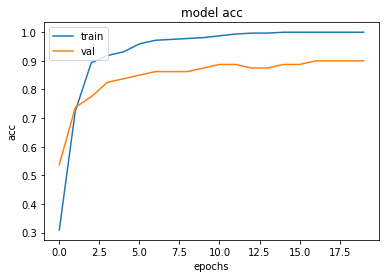

Test loss: 0.44376033544540405
Test accuracy: 0.8999999761581421


In [46]:
# list all data in history
print(history.history.keys())
import matplotlib.pyplot as plt
#Visualize history (loss vs epochs)
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('acc')  
plt.xlabel('epochs')
plt.legend(['train','val'], loc='upper left')
plt.show()

score = classifier.evaluate(x_test, z_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# SVM

In [47]:
import numpy as np

from sklearn import svm

lin_clf = svm.SVC(kernel='linear')

#history_clf = lin_clf.fit(x_train,y_train) 
history_clf = lin_clf.fit(x_train, y_train)

In [48]:
print(history_clf)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [49]:
y_pred_svm = lin_clf.predict(x_test)
print(y_pred_svm,y_pred_svm.shape)

[9 8 3 1 6 5 2 6 3 8 8 7 6 9 8 1 8 8 7 3 2 8 7 9 6 1 3 7 9 7 1 6 9 6 7 4 5
 2 1 9 9 9 0 7 3 9 5 6 5 1 1 8 2 7 7 6 3 2 2 6 4 1 1 3 6 1 5 5 0 9 5 9 8 3
 6 8 3 3 8 4] (80,)


In [50]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred_svm)

0.8625

In [51]:
from sklearn.metrics import confusion_matrix
import itertools

class_names = [str(i) for i in range(10)]

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


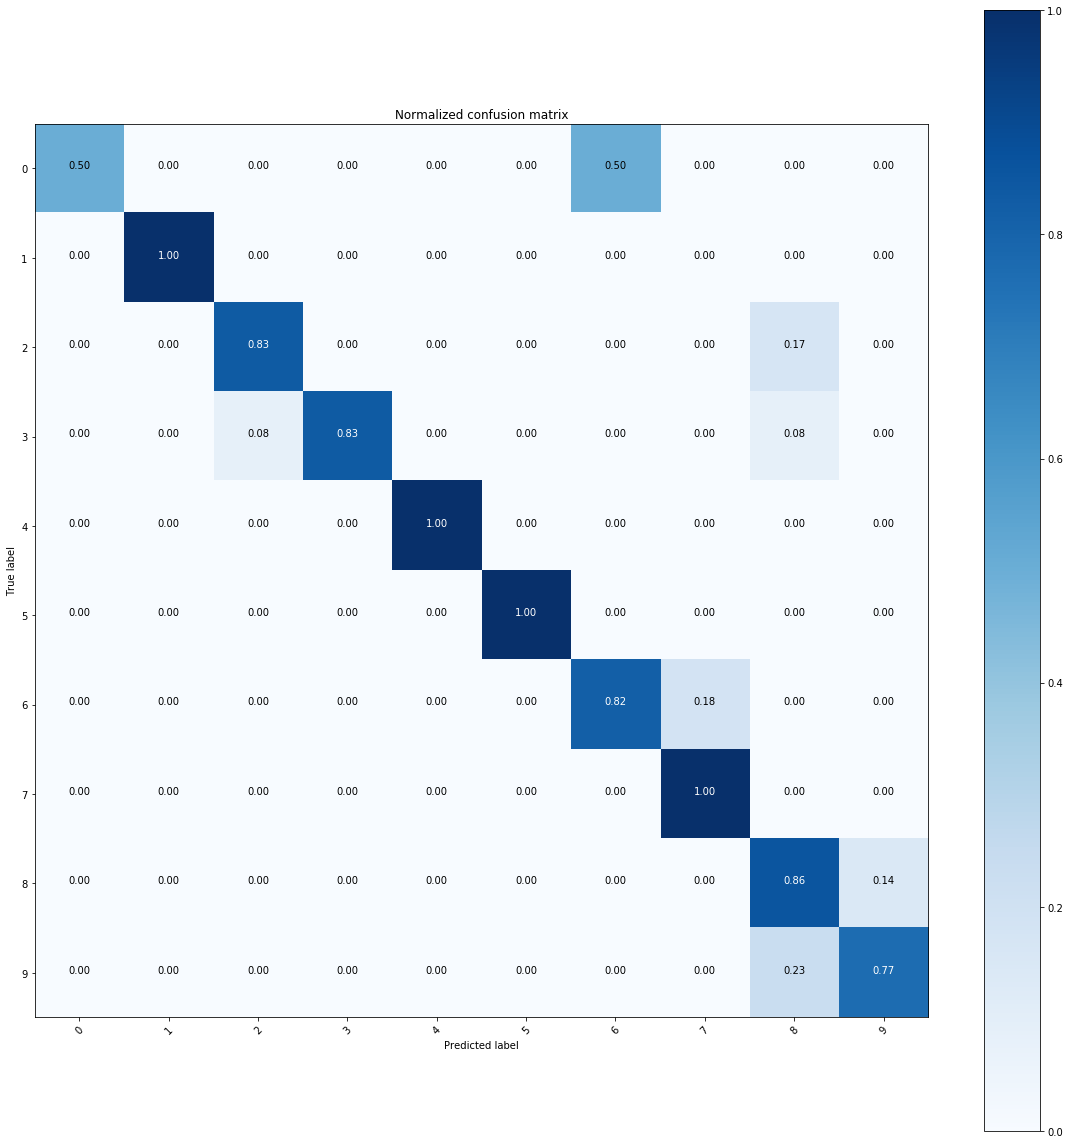

In [52]:
# Compute confusion matrix
def visualize_confusion_matrix(y_test, y_pred):
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)

    # Plot normalized confusion matrix
    plt.figure(figsize=(16,16))
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()

visualize_confusion_matrix(y_test, y_pred_svm)

In [53]:
def toPredict(model,x_test):
    z_pred = model.predict(x_test,64,verbose=1)
    return np.argmax(z_pred,axis=1)

80/80 [==============================] - 0s 399us/step
Normalized confusion matrix


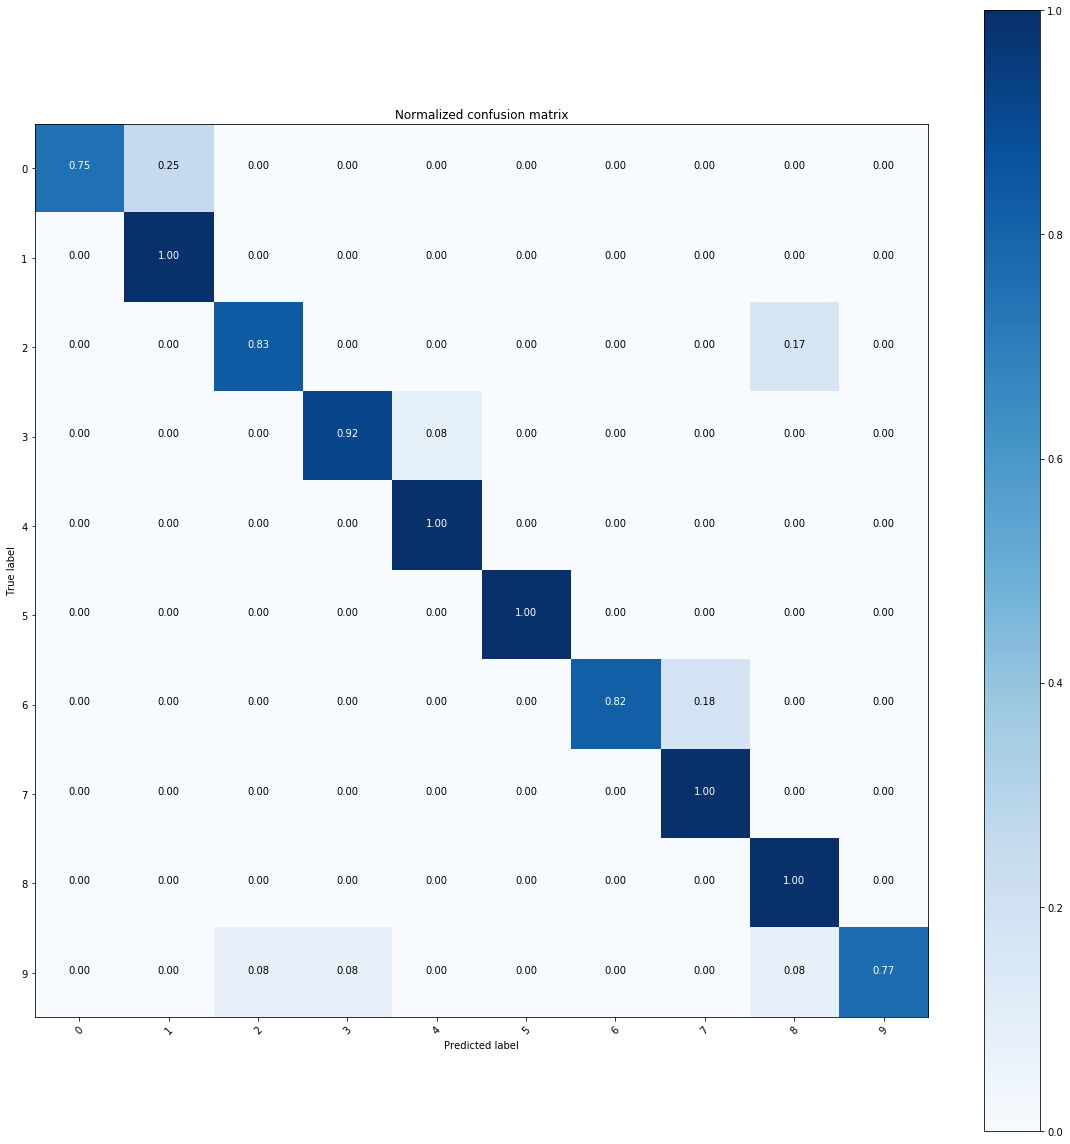

In [54]:
#model dense
y_pred_c = toPredict(classifier,x_test)
visualize_confusion_matrix(y_test, y_pred_c)